In [2]:
conf = dict()
conf['use_sample_only'] = 0
# Save weights
conf['save_weights'] = 1
# How many patients will be in train and validation set during training. Range: (0; 1)
conf['train_valid_fraction'] = 0.5
# Batch size for CNN [Depends on GPU and memory available]
conf['batch_size'] = 20
# Number of epochs for CNN training
conf['nb_epoch'] = 1
# Early stopping. Stop training after epochs without improving on validation
conf['patience'] = 1
# Shape of image for CNN (Larger the better, but you need to increase CNN as well)
conf['image_shape'] = (64, 64)
# Learning rate for CNN. Lower better accuracy, larger runtime.
conf['learning_rate'] = 1e-2
# Number of random samples to use during training per epoch 
conf['samples_train_per_epoch'] = 10000
# Number of random samples to use during validation per epoch
conf['samples_valid_per_epoch'] = 1000
# Some variables to control CNN structure
conf['level_1_filters'] = 4
conf['level_2_filters'] = 8
conf['dense_layer_size'] = 32
conf['dropout_value'] = 0.5


import dicom 
import os
import cv2
import numpy as np
import pandas as pd
import glob
import random
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
np.random.seed(2016)
random.seed(2016)


C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [17]:
def load_and_normalize_dicom(path, x, y):
    dicom1 = dicom.read_file(path)
    dicom_img = dicom1.pixel_array.astype(np.float64)
    mn = dicom_img.min()
    mx = dicom_img.max()
    if (mx - mn) != 0:
        dicom_img = (dicom_img - mn)/(mx - mn)
    else:
        dicom_img[:, :] = 0
    if dicom_img.shape != (x, y):
        dicom_img = cv2.resize(dicom_img, (x, y), interpolation=cv2.INTER_CUBIC)
    return dicom_img



In [ ]:


def batch_generator_train(files, train_csv_table, batch_size):
    number_of_batches = np.ceil(len(files)/batch_size)
    counter = 0
    random.shuffle(files)
    while True:
        batch_files = files[batch_size*counter:batch_size*(counter+1)]
        image_list = []
        mask_list = []
        for f in batch_files:
            image = load_and_normalize_dicom(f, conf['image_shape'][0], conf['image_shape'][1])
            patient_id = os.path.basename(os.path.dirname(f))
            is_cancer = train_csv_table.loc[train_csv_table['id'] == patient_id]['cancer'].values[0]
            if is_cancer == 0:
                mask = [1, 0]
            else:
                mask = [0, 1]
            image_list.append([image])
            mask_list.append(mask)
        counter += 1
        image_list = np.array(image_list)
        mask_list = np.array(mask_list)
#         print(image_list.shape)
#         print(mask_list.shape)
        yield image_list, mask_list
        if counter == number_of_batches:
            random.shuffle(files)
            counter = 0


In [ ]:


def get_custom_CNN():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(1, conf['image_shape'][0], conf['image_shape'][1]), dim_ordering='th'))
    model.add(Convolution2D(conf['level_1_filters'], 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(conf['level_1_filters'], 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering='th'))

    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(conf['level_2_filters'], 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(conf['level_2_filters'], 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering='th'))

    model.add(Flatten())
    model.add(Dense(conf['dense_layer_size'], activation='relu'))
    model.add(Dropout(conf['dropout_value']))
    model.add(Dense(conf['dense_layer_size'], activation='relu'))
    model.add(Dropout(conf['dropout_value']))

    model.add(Dense(2, activation='softmax'))

    sgd = SGD(lr=conf['learning_rate'], decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:

def get_train_single_fold(train_data, fraction):
    ids = train_data['id'].values
#     print("Patient Ids:",len(ids))
    random.shuffle(ids)
    split_point = int(round(fraction*len(ids)))
    train_list = ids[:split_point]
    valid_list = ids[split_point:]
    return train_list, valid_list



In [23]:

train_csv_table = pd.read_csv('D:/FYP/Data Sets/Labels/stage1_labels.csv')
train_patients, valid_patients = get_train_single_fold(train_csv_table, conf['train_valid_fraction'])
print('Train patients: {}'.format(len(train_patients)))
print('Valid patients: {}'.format(len(valid_patients)))

print('Create and compile model...')
model = get_custom_CNN()
callbacks = [
    EarlyStopping(monitor='val_loss', patience=conf['patience'], verbose=0),
    # ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True, verbose=0),
]

get_dir = 'stage1'
#     if conf['use_sample_only'] == 1:
#         get_dir = 'sample_images'

train_files = []
for p in train_patients:
    train_files += glob.glob("D:/FYP/Data Sets/{}/{}/*.dcm".format(get_dir, p))
#     print(train_files)
print('Number of train files: {}'.format(len(train_files)))

valid_files = []
for p in valid_patients:
    valid_files += glob.glob("D:/FYP/Data Sets/{}/{}/*.dcm".format(get_dir, p))
print('Number of valid files: {}'.format(len(valid_files)))

print('Fit model...')
print('Samples train: {}, Samples valid: {}'.format(conf['samples_train_per_epoch'], conf['samples_valid_per_epoch']))
fit = model.fit_generator(generator=batch_generator_train(train_files, train_csv_table, conf['batch_size']),
                      nb_epoch=conf['nb_epoch'],
                      samples_per_epoch=conf['samples_train_per_epoch'],
                      validation_data=batch_generator_train(valid_files, train_csv_table, conf['batch_size']),
                      nb_val_samples=conf['samples_valid_per_epoch'],
                      verbose=1,
                      callbacks=callbacks)



Patient Ids: 1595
Train patients: 798
Valid patients: 797
Create and compile model...


C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((1, 1), input_shape=(1, 64, 64..., data_format="channels_first")`
  """
C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), activation="relu", data_format="channels_first")`
  
C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((1, 1), data_format="channels_first")`
  import sys
C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), activation="relu", data_format="channels_first")`
  
C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: UserWarning: Update yo

Number of train files: 142283
Number of valid files: 143097
Fit model...
Samples train: 10000, Samples valid: 1000


C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:37: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\aliza\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_data=<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=10000, epochs=1, validation_steps=1000)`


Epoch 1/1
(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64)
(20, 2)
    1/10000 [..............................] - ETA: 7:41:39 - loss: 0.6903 - acc: 0.6000(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64)
(20, 2)
    2/10000 [..............................] - ETA: 5:41:50 - loss: 0.6884 - acc: 0.5750(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64)
(20, 2)
    3/10000 [..............................] - ETA: 5:35:25 - loss: 0.6864 - acc: 0.6167(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64)
(20, 2)
    4/10000 [..............................] - ETA: 5:22:28 - loss: 0.6873 - acc: 0.6125(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64)
(20, 2)
    5/10000 [..............................] - ETA: 5:17:43 - loss: 0.6815 - acc: 0.6500(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64)
(20, 2)
    6/10000 [..............................] - ETA: 5:05:57 - loss: 0.6768 - acc: 0.6667(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64)
(20, 2)
    7/10000 [..............................] - ETA: 4:49:25 - loss: 0.6784 - acc: 0.6643(20, 1, 64, 64)
(20, 2)
(20, 1, 64, 64

KeyboardInterrupt: 

In [ ]:

model = create_single_model()
model.save_weights('mdl.h5')
model.save("Deep_Neural_weights.h5")
#create_submission(model)


In [3]:
from keras.models import load_model
model_cnn = load_model("Deep_Neural_weights.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [4]:
model_cnn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_45 (ZeroPaddi (None, 1, 66, 66)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 4, 64, 64)         40        
_________________________________________________________________
zero_padding2d_46 (ZeroPaddi (None, 4, 66, 66)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 4, 64, 64)         148       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 4, 32, 32)         0         
_________________________________________________________________
zero_padding2d_47 (ZeroPaddi (None, 4, 34, 34)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 8, 32, 32)         296       
__________

In [6]:
import matplotlib.pyplot as plt

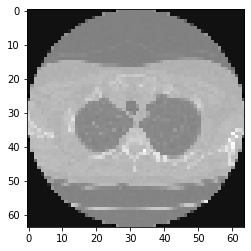

[[[[-2000 -2000 -2000 ... -2000 -2000 -2000]
   [-2000 -2000 -2000 ... -2000 -2000 -2000]
   [-2000 -2000 -2000 ... -2000 -2000 -2000]
   ...
   [-2000 -2000 -2000 ... -2000 -2000 -2000]
   [-2000 -2000 -2000 ... -2000 -2000 -2000]
   [-2000 -2000 -2000 ... -2000 -2000 -2000]]]]
Class: [1]


In [15]:
image_list=[]
dicom1 = dicom.read_file("Testing/0af07f64d14d6b0451036cc742a96fbf.dcm")

dicom_img = dicom1.pixel_array
#     mn = dicom_img.min()
#     mx = dicom_img.max()
#     if (mx - mn) != 0:
#         dicom_img = (dicom_img - mn)/(mx - mn)
#     else:
#         dicom_img[:, :] = 0
#     if dicom_img.shape != (64, 64):
dicom_img = cv2.resize(dicom_img, (64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(dicom_img, cmap='gray')
plt.show()

#     print(dicom_img.shape)
image_list.append([dicom_img])
#     print(image_list)
image_list = np.array(image_list)
print(image_list)
classes = model_cnn.predict_classes(image_list)
print("Class:",classes)


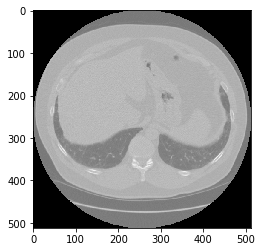

In [14]:
dicom1 = dicom.read_file("Testing/0b2d859a80dda2bb28b26ae0ba9f3607.dcm")
dicom_img = dicom1.pixel_array.astype(np.float64)
# image=cv2.resize(dicom_img, (200, 200), interpolation=cv2.INTER_CUBIC)
plt.imshow(dicom_img,cmap='gray')
plt.show()
# cv2.imwrite("image_processed.jpg",dicom_img)

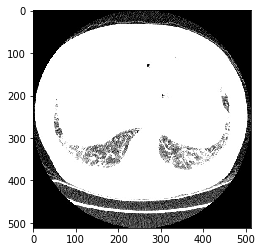

In [150]:
a=cv2.imread("image_processed.jpg")
plt.imshow(a, cmap='gray')
plt.show()


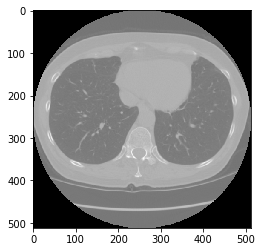

In [156]:
dicom1 = dicom.read_file("Uploaded_file.dcm")
dicom_img = dicom1.pixel_array.astype(np.float64)
# image=cv2.resize(dicom_img, (200, 200), interpolation=cv2.INTER_CUBIC)
plt.imshow(dicom_img,cmap='gray')
plt.show()